In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

import keras
print(f"keras version: {keras.__version__}")
from keras import layers, losses, ops
from keras import backend as K


print(f"Keras Backend == {K.backend()}")

2024-09-05 15:38:48.884371: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-05 15:38:48.963460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 15:38:48.999928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 15:38:49.010276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 15:38:49.073720: I tensorflow/core/platform/cpu_feature_guar

tensorflow version: 2.17.0
keras version: 3.4.1
Keras Backend == tensorflow


### Check for GPU availability

In [2]:
num_gpu = tf.config.list_physical_devices('GPU')
print(f"# of available GPUs: {len(num_gpu)}")

# of available GPUs: 1


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-09-05 15:38:51.077460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14087 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:2d:00.0, compute capability: 8.6


In [4]:
!nvidia-smi

Thu Sep  5 15:38:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4000               Off | 00000000:2D:00.0 Off |                  Off |
| 46%   57C    P2              25W / 140W |    482MiB / 16376MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## loading the Data

In [5]:
# Image pixel values are already normalized between 0 and 1

X = np.load('tiles.npy', allow_pickle=True)
N, h, w= X.shape

X = X.reshape(N, h, w, 1)
# 128 == 2^7

In [6]:
X_train, X_test = train_test_split(
    X,
    test_size= 0.1,
    shuffle= True,
    random_state= 48,
)

X_train, X_val = train_test_split(
    X_train,
    test_size= 0.11111, # to achieve 80:10:10 split
    shuffle= True,
    random_state= 48
)

print(f"X_train set size: {X_train.shape, type(X_train)} \nX_test set size: {X_test.shape, type(X_test)} \nX_validation set size: {X_val.shape, type(X_val)}")

X_train set size: ((32320, 128, 128, 1), <class 'numpy.ndarray'>) 
X_test set size: ((4040, 128, 128, 1), <class 'numpy.ndarray'>) 
X_validation set size: ((4040, 128, 128, 1), <class 'numpy.ndarray'>)


In [7]:
X_train = tf.convert_to_tensor(X_train, dtype='float32')
X_val = tf.convert_to_tensor(X_val, dtype='float32')
X_test = tf.convert_to_tensor(X_test, dtype='float32')

Why use dataloaders?

It is designed to handle large datasets efficiently and can be configured to load data in parallel, preprocess data on the fly, and shuffle data for each epoch. This makes it incredibly quick for models to train on GPU if data can be loaded in parallel.

## creating the Layers

In [8]:
# model params

latent_dim = 16
shape = (h, w, 1)

latent_dim, shape

(16, (128, 128, 1))

In [9]:
@keras.saving.register_keras_serializable()
#Sampler
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        std = ops.exp(0.5 * z_log_var)
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + std * epsilon

In [10]:
#Encoder
encoder_inputs = keras.Input(shape=shape)
# convolutional layer
x = layers.Conv2D(32, 3, activation="leaky_relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="leaky_relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="leaky_relu", strides=2, padding="same")(x)

# fully-connected layer
x = layers.Flatten()(x)
x = layers.Dense(16, activation="leaky_relu")(x)

# latent space
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
# building the layer
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


#Decoder
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(16 * 16 * 128, activation="leaky_relu")(latent_inputs)
x = layers.Reshape((16, 16, 128))(x)
# Transpose convolutions
x = layers.Conv2DTranspose(128, 3, activation="leaky_relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="leaky_relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="leaky_relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
# building the layer
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32768)     │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │    524,304 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │        272 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │        272 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 617,520 (2.36 MB)

 Trainable params: 617,520 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32768)          │       557,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 1)    │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 797,185 (3.04 MB)

 Trainable params: 797,185 (3.04 MB)

 Non-trainable params: 0 (0.00 B)

## defining the Model with custom training step

In [11]:
@keras.saving.register_keras_serializable()
class VAE(keras.Model):
    def __init__(self, encoder, decoder, sampling=Sampling, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        
    # def get_config(self):
    #     config = super().get_config()
    #     config.update({
    #             "encoder_layer": keras.saving.serialize_keras_object(self.encoder),
    #             "decoder_layer": keras.saving.serialize_keras_object(self.decoder),
    #         })
    #     return config
        
    # @classmethod
    # def from_config(cls, config):
        
    #     config["encoder"] = keras.saving.deserialize_keras_object(config["encoder"])
    #     config["decoder"] = keras.saving.deserialize_keras_object(config["decoder"])
    #     return cls(**config)
    
    def call(self, x):
        z_mean, z_log_var, encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded, z_mean, z_log_var
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        "Custom training loop using gradient descent"
        
        with tf.GradientTape() as tape:

            # MODEL
            # Create latent embeddings (mu & logvar)
            z_mean, z_log_var, z = self.encoder(data)
            
            # Reconstruct input by decoding latent space
            reconstruction = self.decoder(z)
            
            # LOSS
            # Find the loss between the input and reconstructed output

            # Using MSE
            reconstruction_loss = ops.mean(
                ops.sum(keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2),))
            
            # Using BCE
            # reconstruction_loss = ops.mean(
            #     ops.sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2),)
            # )
            # reconstruction_loss = keras.losses.binary_crossentropy(data, reconstruction)
            

            # KL measures how close to the VI inference was to the posterior: how well they infer 
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Loss trackers
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## train the Model

In [12]:
vae = VAE(encoder, decoder)
vae.build(shape)
# -----------------------------------------------------------------------------------------------------------------

vae.compile(
    optimizer= keras.optimizers.AdamW(learning_rate=0.001),
    loss= keras.losses.KLDivergence,
    metrics= [keras.metrics.KLDivergence],
)

# Initiate early stopping
EarlyStop = keras.callbacks.EarlyStopping(
    monitor= 'reconstruction_loss', patience= 3, mode='min')
# -----------------------------------------------------------------------------------------------------------------
#Training hyperparameters
batch_size = 128

# create dataloaders of each dataset

train_dataset = tf.data.Dataset.from_tensor_slices((X_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val))
val_dataset = val_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test))
test_dataset = test_dataset.batch(batch_size)


print("Fitting model on training dataset")
history = vae.fit(
    train_dataset,
    epochs= 450,
    batch_size= batch_size,
    # callbacks= [EarlyStop], 

    # validation_data=val_dataset,
)
print("Model has been fitted on training dataset")

# print(vae.get_config())

history.model.save_weights('pretrained_vae.weights.h5')
print("Model weights has been saved!")

Fitting model on training dataset
Epoch 1/450


I0000 00:00:1725547144.198454 2001417 service.cc:146] XLA service 0x7f91280072b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725547144.198970 2001417 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-09-05 15:39:04.338821: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-05 15:39:04.629296: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-05 15:39:12.040082: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packag

  3/253 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - kl_loss: 0.3776 - loss: 246.9144 - reconstruction_loss: 246.5368 

I0000 00:00:1725547152.838606 2001417 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


253/253 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - kl_loss: 6.2046 - loss: 157.7503 - reconstruction_loss: 151.5458
Epoch 2/450
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - kl_loss: 5.2131 - loss: 78.6614 - reconstruction_loss: 73.4483
Epoch 3/450
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - kl_loss: 5.2500 - loss: 75.9958 - reconstruction_loss: 70.7458
Epoch 4/450
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - kl_loss: 5.3260 - loss: 74.4796 - reconstruction_loss: 69.1536
Epoch 5/450
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - kl_loss: 5.7138 - loss: 72.9452 - reconstruction_loss: 67.2314
Epoch 6/450
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - kl_loss: 5.7772 - loss: 72.2871 - reconstruction_loss: 66.5099
Epoch 7/450
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - kl_loss: 6.4468 - loss: 70.9414 - reconstruction_loss: 64.4946
Epoch 8/450
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - kl_loss: 7.0202 - loss: 70.0636 - reconstruction_loss: 63.0434
Epoch 9/450
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/

In [13]:
# reconstruction_loss = []
# for rc_loss in history.history['reconstruction_loss']:
#     # recalc = rc_loss / 1000
#     reconstruction_loss.append(recalc)
    
x = history.epoch
kl_loss = history.history['kl_loss']
recon_loss = history.history['reconstruction_loss']

# plt.title(f"Training Loss against Epochs, Latent dimension = {latent_dim}")
# plt.plot(x, kl_loss, 'orange', label="$D_{KL}$ Loss")
# plt.plot(x, recon_loss, '-.', c='blue', label= "Reconstruction Loss")
# # plt.plot(x, elbo, 'green', label= "ELBO Loss")
# plt.xlabel('Epochs')
# plt.ylabel("$D_{KL}$ & Reconstruction Loss")
# plt.legend(["$D_{KL}$ Loss", "Reconstruction Loss","ELBO"])
# # plt.savefig("Training_Loss.jpg")

# plt.show()

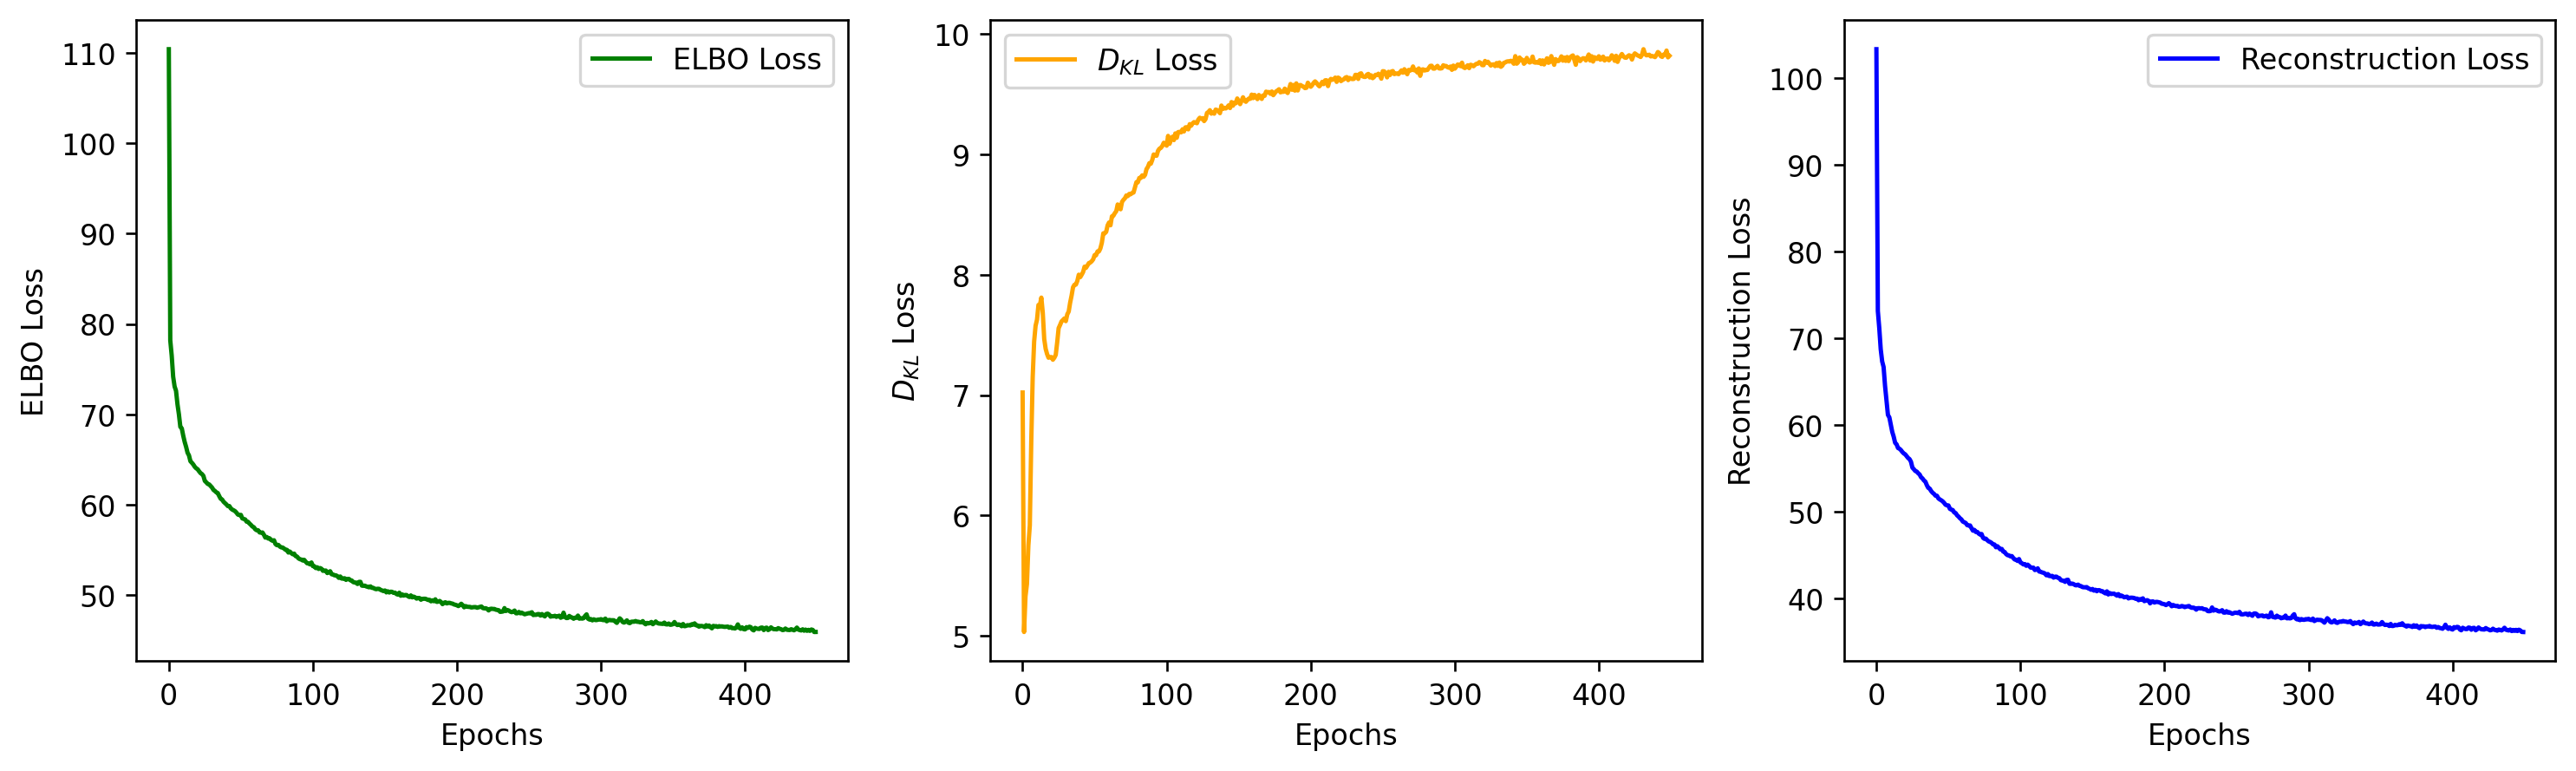

In [14]:
# fig = plt.figure(figsize=(10,10))
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3,
                                  # sharex=True,
                                  figsize=(15,4), dpi=240)
fig.subplots_adjust(hspace=0)
# ax1 = plt.subplot(311)
# ax2 = plt.subplot(312)
# ax3 = plt.subplot(313)

ax3.plot(x, recon_loss, c='blue', label= "Reconstruction Loss")
ax3.set_xlabel('Epochs')
ax3.set_ylabel("Reconstruction Loss")
ax3.legend(["Reconstruction Loss"])

ax2.plot(x, kl_loss, 'orange', label="$D_{KL}$ Loss")
ax2.set_xlabel('Epochs')
ax2.set_ylabel("$D_{KL}$ Loss")
ax2.legend(["$D_{KL}$ Loss"])

elbo = history.history['loss']
ax1.plot(x, elbo, 'green')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("ELBO Loss")
ax1.legend(["ELBO Loss"])

fig.savefig('all_losses_1x3.png')
fig.show()

### Load model

In [15]:
trained_vae = VAE(encoder, decoder)
trained_vae.build(shape)

In [16]:
# trained_vae = keras.models.clone_model(vae)
trained_vae.load_weights("pretrained_vae.weights.h5")

## Reconstructing from the test dataset

In [17]:
mu,sigma,z = trained_vae.encoder.predict(X_test)

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [18]:
pred = trained_vae.predict(test_dataset,)# batch_size= 64,)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step


In [19]:
%%time
# Reconstruct using the held out test samples
with tf.device('/CPU:0'):
    _, _, encoded_img = trained_vae.encoder(X_test)
    print(f"Encoded step complete \nz = {encoded_img.shape}")

# Reconstruct using the held out test samples continued
    X_hat = trained_vae.decoder(encoded_img).numpy()
    print(X_hat.shape)

Encoded step complete 
z = (4040, 16)
(4040, 128, 128, 1)
CPU times: user 2min 3s, sys: 2min 11s, total: 4min 15s
Wall time: 3.51 s


Latent Dimension == 16
Hyperparameters: 
Batch_size: 128


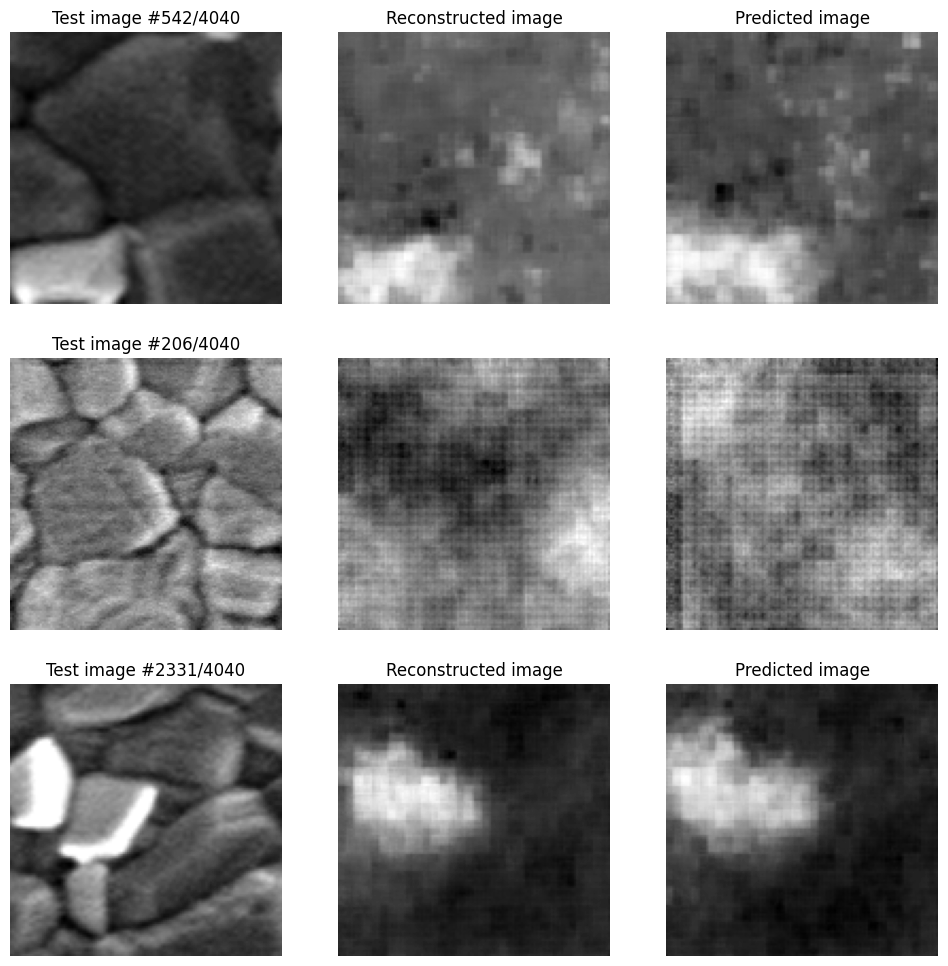

In [74]:
# Visualise the reconstructed and predicted output
m = np.random.randint(0, len(X_test))
n = np.random.randint(0, len(X_test))
o = np.random.randint(0, len(X_test))

print(f"Latent Dimension == {latent_dim}\nHyperparameters: \nBatch_size: {batch_size}")

#------------------------------------------------------------------------------
plt.figure(figsize=(12,12))

plt.subplot(331)
plt.title(f"Test image #{m+1}/{len(X_test)}")
plt.imshow(X_test[m], 'gray')
plt.axis('off')
plt.subplot(332)
plt.title("Reconstructed image")
plt.imshow(X_hat[m], 'gray')
plt.axis('off')
plt.subplot(333)
plt.title("Predicted image")
plt.imshow(pred[0][m], 'gray')
plt.axis('off')

plt.subplot(334)
plt.title(f"Test image #{205+1}/{len(X_test)}")
plt.imshow(X_test[n], 'gray')
plt.axis('off')
plt.subplot(335)
plt.imshow(X_hat[n], 'gray')
plt.axis('off')
plt.subplot(336)
plt.imshow(pred[0][n], 'gray')
plt.axis('off')

plt.subplot(337)
plt.title(f"Test image #{2330+1}/{len(X_test)}")
# \nBatch_size: {batch_size}")
plt.imshow(X_test[o], 'gray')
plt.axis('off')
plt.subplot(338)
plt.title("Reconstructed image")
plt.imshow(X_hat[o], 'gray')
plt.axis('off')
plt.subplot(339)
plt.title("Predicted image")
plt.imshow(pred[0][o], 'gray')
plt.axis('off')

plt.show()

<br>

<br>

Reconstruction = what the model reproduces from inputs

Prediction should look the same as reconstruction; present as sense check

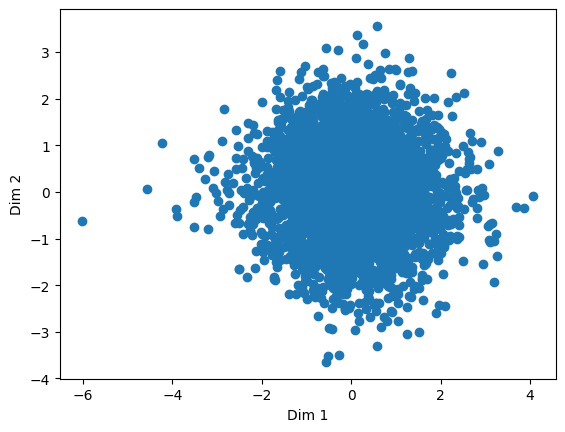

In [21]:
plt.scatter(z[:,0], z[:,1])
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [23]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(z)
tsne.kl_divergence_

3.170543909072876

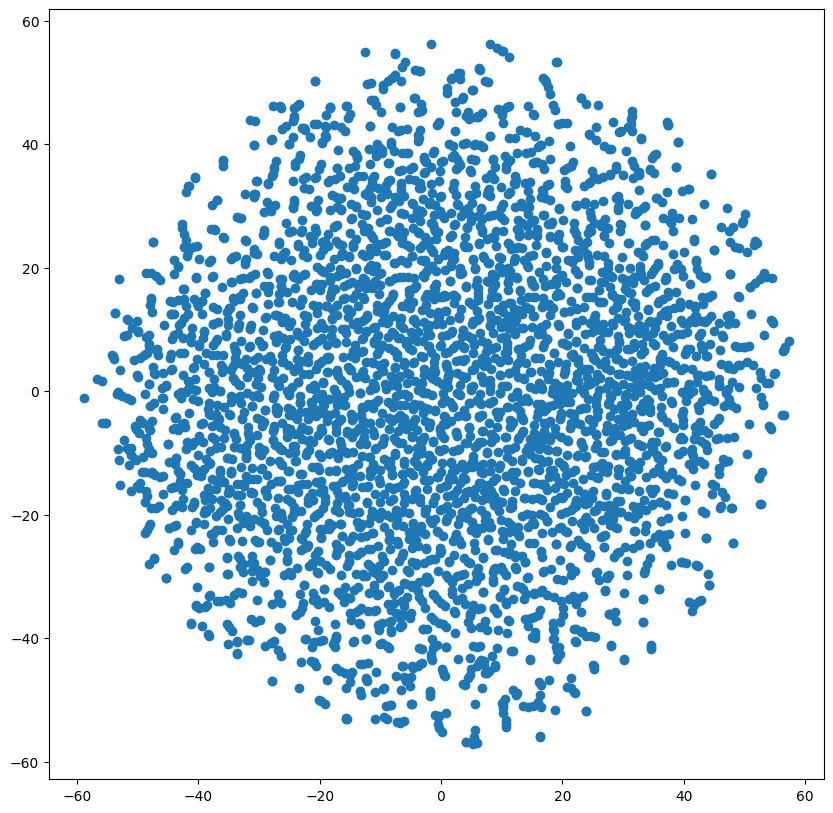

In [49]:
plt.figure(figsize=(10,10),
           # dpi=240
          )
plt.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1])
# plt.title("t-SNE visualization of 2 components")
# plt.xticks([])
# plt.yticks([])
# plt.xlabel("First t-SNE")
# plt.ylabel("Second t-SNE")
# plt.savefig("Latent_space_tSNE.png")
plt.show()

In [37]:
x=X_tsne[:, 0]
y=X_tsne[:, 1]

np.where(((x<24.5) & (x>19.5)) & ((y<5) & (y>-5)))
# np.where(((x<-14) & (x>-26)) & ((y<46) & (y>34)))

(array([  80,  110,  338,  400,  431,  571,  645,  836,  839, 1151, 1168,
        1185, 1455, 1714, 1821, 1934, 2026, 2049, 2082, 2134, 2453, 2500,
        2510, 2566, 2624, 2726, 2992, 3006, 3011, 3081, 3188, 3312, 3372,
        3584, 3869, 3925, 3931]),)

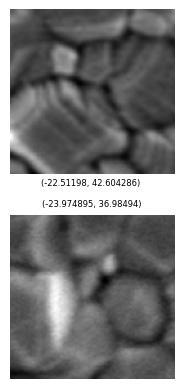

In [45]:
c = 'gray'

fig1, (ax1,ax2) = plt.subplots(nrows=2, 
                               sharex = True, sharey=True,
                               # dpi= 240
                              )
fig1.subplots_adjust(hspace=0.25) 

ax1.imshow(X_test[29],c)
ax1.axis('off')

ax2.set_title(f"{x[29],y[29]} \n \n{x[187],y[187]}",
              fontdict={'fontsize':6})
ax2.imshow(X_test[3883],c)
ax2.axis('off')
fig1.savefig('first_point.png')
fig1.show()

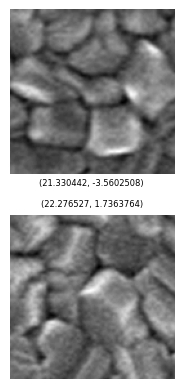

In [44]:
fig2, (ax3,ax4) = plt.subplots(nrows=2, 
                               sharex = True, sharey=True,
                               # dpi=240,
                              )
fig2.subplots_adjust(hspace=0.25)

ax3.imshow(X_test[3931],c)
ax3.axis('off')

ax4.set_title(f"{x[3931],y[3931]} \n \n{x[3925],y[3925]}",
              fontdict={'fontsize':6})
ax4.imshow(X_test[3925],c)
ax4.axis('off')

fig2.savefig('second_point.png')
fig2.show()